In [1]:
import os
import time
import warnings

import cv2
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

In [33]:
def preparar_dataset_faces(dimensoes_resize, arquivo_saida, usar_pca=False, n_componentes=None):
    """
    Carrega imagens de faces, as pré-processa e salva o dataset em um arquivo.

    A função busca por imagens de faces em um formato de nome específico no diretório
    atual, redimensiona cada imagem, as vetoriza, opcionalmente aplica PCA para
    redução de dimensionalidade, e as salva com seus rótulos em um arquivo de texto.

    Args:
        dimensoes_resize (tuple): Tupla (altura, largura) para o redimensionamento. Ex: (60, 60).
        arquivo_saida (str): Nome do arquivo de texto onde o dataset será salvo.
        usar_pca (bool, optional): Se True, aplica PCA nos dados. Padrão é False.
        n_componentes (int, optional): Número de componentes principais a serem mantidos.
                                       Obrigatório se usar_pca for True.

    Returns:
        bool: True se o dataset foi criado com sucesso, False caso contrário.
    """
    print("--- Iniciando a preparação do dataset de faces ---")

    # --- Validação de Parâmetros ---
    if usar_pca and (n_componentes is None or n_componentes <= 0):
        print("\nErro: Se 'usar_pca' é True, 'n_componentes' deve ser um número inteiro positivo.")
        return False

    # --- Configuração dos nomes de arquivo ---
    part1 = 'subject0'
    part2 = 'subject'
    part3 = [
        '.centerlight', '.glasses', '.happy', '.leftlight', '.noglasses', 
        '.normal', '.rightlight', '.sad', '.sleepy', '.surprised', '.wink'
    ]
    Nind = 15  # Número de indivíduos (classes)

    X_list = []
    Y_list = []

    # --- Loop de carregamento e processamento ---
    print(f"Redimensionando imagens para {dimensoes_resize[0]}x{dimensoes_resize[1]} pixels...")
    for i in range(1, Nind + 1):
        for expression in part3:
            if i < 10:
                nome = f"{part1}{i}{expression}"
            else:
                nome = f"{part2}{i}{expression}"
            
            if not os.path.exists(nome):
                continue

            img = cv2.imread(nome, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                continue

            ar = cv2.resize(img, (dimensoes_resize[1], dimensoes_resize[0]))
            a_mat = ar.astype(np.float64) / 255.0
            a_vec = a_mat.flatten(order='F')
            rot = i

            X_list.append(a_vec)
            Y_list.append(rot)
    
    # --- Verificação e montagem do dataset ---
    if not X_list:
        print("\nErro: Nenhuma imagem foi encontrada. O dataset não foi gerado.")
        return False

    X = np.array(X_list)
    Y = np.array(Y_list).reshape(-1, 1)

    # --- Etapa opcional de PCA ---
    if usar_pca:
        # Verifica se o número de componentes não é maior que o número de amostras
        if n_componentes > X.shape[0]:
            print(f"\nAviso: O número de componentes ({n_componentes}) é maior que o número de amostras ({X.shape[0]}).")
            print(f"Ajustando o número de componentes para {X.shape[0]}.")
            n_componentes = X.shape[0]

        print(f"\nAplicando PCA para reduzir a dimensionalidade para {n_componentes} componentes...")
        pca = PCA(n_components=n_componentes)
        X = pca.fit_transform(X) # fit_transform espera amostras como linhas
        print(f"Dimensionalidade reduzida. Novo formato das features: {X.shape}")

    # Combina features (X) e rótulo (Y) em uma única matriz Z
    Z = np.hstack((X, Y))

    # --- Salvamento do arquivo ---
    try:
        np.savetxt(arquivo_saida, Z, fmt='%.8f')
        print(f"\nProcessamento completo.")
        print(f"Dataset com {Z.shape[0]} amostras e {Z.shape[1]} colunas salvo em '{arquivo_saida}'.")
        return True
    except Exception as e:
        print(f"\nErro ao salvar o arquivo: {e}")
        return False

def executar_analise_modelos(nome_arquivo):
    """
    Executa uma análise comparativa de modelos de regressão para uma tarefa de classificação.

    A função carrega os dados de um arquivo, executa uma validação cruzada de 5 folds
    para cada modelo, calcula estatísticas de acurácia e tempo, e imprime uma
    tabela de resultados formatada no console.

    Args:
        nome_arquivo (str): O caminho para o arquivo de dados (ex: 'recfaces.dat').

    Returns:
        pandas.DataFrame or None: Um DataFrame contendo os resultados compilados da análise,
                                  ou None se o arquivo de dados não for encontrado.
    """
    # --- Configuração Inicial ---
    # Ignorar avisos para manter a saída limpa
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)

    # --- Carregar os Dados ---
    try:
        print(f"Carregando o arquivo '{nome_arquivo}'...")
        data = np.loadtxt(nome_arquivo)
        X = data[:, :-1]
        y = data[:, -1]
        print(f"Dados carregados: {X.shape[0]} amostras, {X.shape[1]} features.")
        print("-" * 50)
    except FileNotFoundError:
        print(f"Erro: O arquivo '{nome_arquivo}' não foi encontrado.")
        return None

    # --- Definir os Modelos de Regressão ---
    regressors = {
        "MQ": LinearRegression(),
        "PL": MLPRegressor(hidden_layer_sizes=(), activation='relu',
                                                  max_iter=100000, random_state=2,solver='sgd'),
        "MLP-1H": MLPRegressor(hidden_layer_sizes=(10,), activation='relu',
                                              max_iter=100000, random_state=2,solver='sgd'),
        "MLP-2H": MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu',
                                                 max_iter=10000, random_state=2,solver='sgd')
    }

    # --- Preparação para Coletar Resultados ---
    results_list = []

    # --- Loop de Execução e Avaliação com Validação Cruzada ---
    for name, model in regressors.items():
        print(f"Avaliando o modelo: {name}...")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])

        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
        fold_accuracies = []
        fold_iterations = []
        fold_times = []
        
        for train_index, test_index in kf.split(X, y):
            start_fold_time = time.time()
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            pipeline.fit(X_train, y_train)
            y_pred_continuous = pipeline.predict(X_test)
            y_pred_class = np.round(y_pred_continuous)
            y_pred_class = np.clip(y_pred_class, 1, 15)
            
            end_fold_time = time.time()
            
            fold_accuracies.append(accuracy_score(y_test, y_pred_class))
            fold_times.append(end_fold_time - start_fold_time)

            if hasattr(pipeline.named_steps['regressor'], 'n_iter_'):
                fold_iterations.append(pipeline.named_steps['regressor'].n_iter_)

        result_dict = {
            'Classificador': name,
            'Acurácia Média': np.mean(fold_accuracies),
            'Acurácia Mín': np.min(fold_accuracies),
            'Acurácia Máx': np.max(fold_accuracies),
            'Acurácia Mediana': np.median(fold_accuracies),
            'Desvio Padrão': np.std(fold_accuracies),
            'Tempo Médio / Fold (s)': np.mean(fold_times),
            'Iterações (Média)': np.mean(fold_iterations) if fold_iterations else np.nan
        }
        
        results_list.append(result_dict)

    # --- Apresentação Final dos Resultados ---
    print("\n" + "="*70)
    print("--- Tabela de Resultados (Validação Cruzada com 10 Folds) ---")
    print("="*70)

    results_df = pd.DataFrame(results_list)
    pd.options.display.float_format = '{:,.4f}'.format
    results_df = results_df.rename(columns={
        'Acurácia Média': 'Média',
        'Acurácia Mín': 'Mínimo',
        'Acurácia Máx': 'Máximo',
        'Acurácia Mediana': 'Mediana'
    })

    # print(results_df[[
    #     'Classificador', 'Média', 'Mínimo', 'Máximo', 'Desvio Padrão', 
    #     'Tempo Médio / Fold (s)', 'Iterações (Média)'
    # ]].to_string(index=False))
    
    # Retorna o DataFrame para uso posterior, se necessário
    return results_df

In [34]:
preparar_dataset_faces(dimensoes_resize=(30, 30), arquivo_saida='recfaces_60x60_sem_pca.dat', usar_pca=False)
executar_analise_modelos('recfaces_60x60_sem_pca.dat')

--- Iniciando a preparação do dataset de faces ---
Redimensionando imagens para 30x30 pixels...

Processamento completo.
Dataset com 165 amostras e 901 colunas salvo em 'recfaces_60x60_sem_pca.dat'.
Carregando o arquivo 'recfaces_60x60_sem_pca.dat'...
Dados carregados: 165 amostras, 900 features.
--------------------------------------------------
Avaliando o modelo: MQ...
Avaliando o modelo: PL...
Avaliando o modelo: MLP-1H...
Avaliando o modelo: MLP-2H...

--- Tabela de Resultados (Validação Cruzada com 10 Folds) ---


,Classificador,Média,Mínimo,Máximo,Mediana,Desvio Padrão,Tempo Médio / Fold (s),Iterações (Média)
0,MQ,0.3375,0.1875,0.5294,0.3327,0.1052,0.0060,NaN
1,PL,0.3636,0.2353,0.5000,0.3640,0.0805,0.0413,512.2000
2,MLP-1H,0.3581,0.2500,0.5000,0.3529,0.0718,0.0556,292.2000
3,MLP-2H,0.4357,0.3125,0.5294,0.4540,0.0650,0.0796,349.9000


In [35]:
preparar_dataset_faces(dimensoes_resize=(30, 30), arquivo_saida='recfaces_60x60_com_pca.dat', usar_pca=True, n_componentes=20)
executar_analise_modelos('recfaces_60x60_com_pca.dat')

--- Iniciando a preparação do dataset de faces ---
Redimensionando imagens para 30x30 pixels...

Aplicando PCA para reduzir a dimensionalidade para 20 componentes...
Dimensionalidade reduzida. Novo formato das features: (165, 20)

Processamento completo.
Dataset com 165 amostras e 21 colunas salvo em 'recfaces_60x60_com_pca.dat'.
Carregando o arquivo 'recfaces_60x60_com_pca.dat'...
Dados carregados: 165 amostras, 20 features.
--------------------------------------------------
Avaliando o modelo: MQ...
Avaliando o modelo: PL...
Avaliando o modelo: MLP-1H...
Avaliando o modelo: MLP-2H...

--- Tabela de Resultados (Validação Cruzada com 10 Folds) ---


,Classificador,Média,Mínimo,Máximo,Mediana,Desvio Padrão,Tempo Médio / Fold (s),Iterações (Média)
0,MQ,0.2114,0.0625,0.3529,0.2059,0.0975,0.0005,NaN
1,PL,0.2176,0.0625,0.3750,0.2059,0.1054,0.0191,436.4000
2,MLP-1H,0.3820,0.1875,0.5625,0.3640,0.1036,0.1628,"2,086.9000"
3,MLP-2H,0.4110,0.1176,0.5882,0.4706,0.1601,0.1376,"1,226.6000"


In [39]:
# -*- coding: utf-8 -*-
"""
Tradução do script MATLAB para processamento de imagens de faces.
Versão final e robusta usando a biblioteca Pillow para leitura de imagens.
"""

# Importação das bibliotecas necessárias em Python
import numpy as np
import os
from PIL import Image  # Importa a biblioteca Pillow
from skimage import transform, util # Ainda usamos skimage para redimensionar

print("Iniciando o pré-processamento de imagens...")

# --- Fase 1: Carrega as imagens disponíveis ---

part3 = ['.centerlight', '.glasses', '.happy', '.leftlight', '.noglasses', '.normal', '.rightlight', '.sad', '.sleepy', '.surprised', '.wink']
Nind = 15
Nexp = len(part3)

X_list = []
Y_list = []

# Loop sobre cada indivíduo
for i in range(1, Nind + 1):
    print(f"Processando indivíduo: {i}")

    # Loop sobre cada expressão do indivíduo
    for expression in part3:
        # Monta o nome do arquivo sem extensão
        filename = f"subject{i:02d}{expression}"

        try:
            # --- BLOCO DE LEITURA SUBSTITUÍDO ---
            # 1. Abre a imagem com Pillow
            pil_img = Image.open(filename)
            
            # 2. Converte para escala de cinza ('L' de Luminância) de forma explícita
            pil_img_gray = pil_img.convert('L')
            
            # 3. Converte a imagem Pillow para um array NumPy. Agora temos certeza que é 2D.
            img_gray = np.array(pil_img_gray)
            # --- FIM DO BLOCO DE LEITURA ---

            # O resto do código continua como antes
            resized_img = transform.resize(img_gray, (30, 30))
            A = util.img_as_float(resized_img)
            a = A.flatten(order='F')
            label = i

            X_list.append(a)
            Y_list.append(label)

        except FileNotFoundError:
            print(f"  --> Aviso: Arquivo '{filename}' não encontrado. Pulando.")
            continue

# --- Fase 2: Montagem e Salvamento dos Dados ---
print("\nProcessamento concluído.")

if not X_list:
    print("\nERRO: Nenhuma imagem foi processada. A lista de dados está vazia.")
    print("Verifique se os arquivos de imagem estão na pasta correta.")
else:
    X = np.array(X_list).T
    Y = np.array(Y_list)
    
    print("Dimensões da matriz de dados (X):", X.shape)
    print("Dimensões do vetor de rótulos (Y):", Y.shape)
    
    Z = np.vstack((X, Y.reshape(1, -1)))
    Z = Z.T
    
    print("\nDimensões da matriz final (Z) para salvamento:", Z.shape)
    np.savetxt("recfaces.dat", Z, fmt='%.8f')
    print("\nDados pré-processados foram salvos no arquivo 'recfaces.dat'.")

Iniciando o pré-processamento de imagens...
Processando indivíduo: 1
Processando indivíduo: 2
Processando indivíduo: 3
Processando indivíduo: 4
Processando indivíduo: 5
Processando indivíduo: 6
Processando indivíduo: 7
Processando indivíduo: 8
Processando indivíduo: 9
Processando indivíduo: 10
Processando indivíduo: 11
Processando indivíduo: 12
Processando indivíduo: 13
Processando indivíduo: 14
Processando indivíduo: 15

Processamento concluído.
Dimensões da matriz de dados (X): (900, 165)
Dimensões do vetor de rótulos (Y): (165,)

Dimensões da matriz final (Z) para salvamento: (165, 901)

Dados pré-processados foram salvos no arquivo 'recfaces.dat'.


Dados carregados. Formato de X: (165, 900)

--- Análise de Variância Explicada ---
O valor de 'q' escolhido para preservar 98% da variância é: 49
Com 49 componentes, a variância preservada é de: 0.9803 (98.03%)


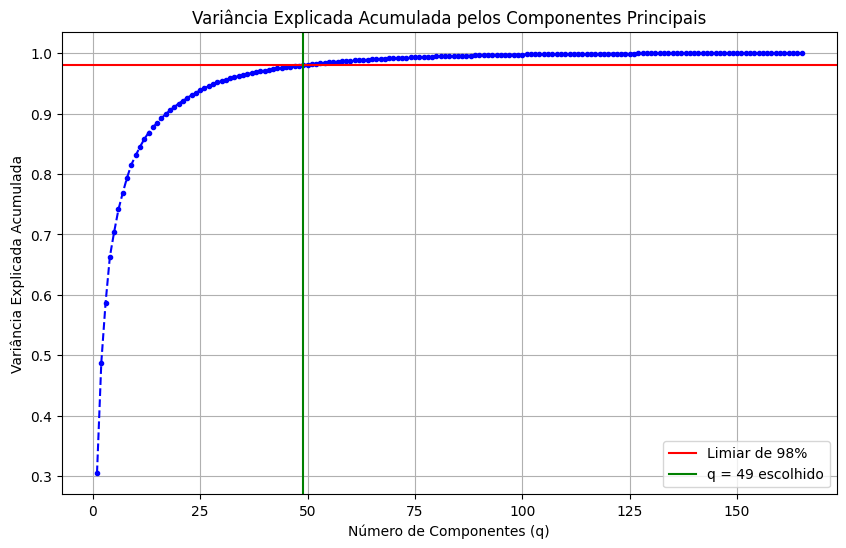

In [40]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Carregando seus dados ---
# Certifique-se que o arquivo 'recfaces.dat' está na mesma pasta
try:
    Z = np.loadtxt("recfaces.dat")
except FileNotFoundError:
    print("Erro: Arquivo 'recfaces.dat' não encontrado.")
    print("Certifique-se de que o script de pré-processamento foi executado com sucesso.")
    exit()

# Separa as características (X) dos rótulos (Y)
# X contém as 900 colunas de pixels, Y contém a última coluna (rótulo)
X = Z[:, :-1]
Y = Z[:, -1]

print(f"Dados carregados. Formato de X: {X.shape}")

# 1. PADRONIZAR OS DADOS
#    Este passo é crucial para o PCA funcionar corretamente.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. APLICAR PCA COM TODOS OS COMPONENTES
#    Para descobrir a contribuição de cada um, não especificamos 'n_components'
pca_full = PCA()
pca_full.fit(X_scaled)

# 3. CALCULAR A VARIÂNCIA EXPLICADA ACUMULADA
#    Soma cumulativa da porcentagem de variância de cada componente
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# 4. ENCONTRAR O 'q' QUE ATINGE 98%
#    Encontramos o índice do primeiro componente que ultrapassa 0.98
q = np.argmax(cumulative_variance >= 0.98) + 1

# --- Exibição dos Resultados ---

print("\n--- Análise de Variância Explicada ---")
print(f"O valor de 'q' escolhido para preservar 98% da variância é: {q}")
print(f"Com {q} componentes, a variância preservada é de: {cumulative_variance[q-1]:.4f} ({cumulative_variance[q-1]*100:.2f}%)")


# GERAÇÃO DA "FIGURA DE VARIÂNCIA EXPLICADA ACUMULADA"
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--', color='blue')
plt.title('Variância Explicada Acumulada pelos Componentes Principais')
plt.xlabel('Número de Componentes (q)')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)

# Linhas de referência para o limiar de 98% e o 'q' encontrado
plt.axhline(y=0.98, color='r', linestyle='-', label='Limiar de 98%')
plt.axvline(x=q, color='g', linestyle='-', label=f'q = {q} escolhido')

plt.legend()
plt.show()

In [42]:
preparar_dataset_faces(dimensoes_resize=(30, 30), arquivo_saida='recfaces.dat', usar_pca=True, n_componentes=49)
executar_analise_modelos('recfaces_60x60_com_pca.dat')

--- Iniciando a preparação do dataset de faces ---
Redimensionando imagens para 30x30 pixels...

Aplicando PCA para reduzir a dimensionalidade para 49 componentes...
Dimensionalidade reduzida. Novo formato das features: (165, 49)

Processamento completo.
Dataset com 165 amostras e 50 colunas salvo em 'recfaces.dat'.
Carregando o arquivo 'recfaces_60x60_com_pca.dat'...
Dados carregados: 165 amostras, 20 features.
--------------------------------------------------
Avaliando o modelo: MQ...
Avaliando o modelo: PL...
Avaliando o modelo: MLP-1H...
Avaliando o modelo: MLP-2H...

--- Tabela de Resultados (Validação Cruzada com 10 Folds) ---


,Classificador,Média,Mínimo,Máximo,Mediana,Desvio Padrão,Tempo Médio / Fold (s),Iterações (Média)
0,MQ,0.2114,0.0625,0.3529,0.2059,0.0975,0.0005,NaN
1,PL,0.2176,0.0625,0.3750,0.2059,0.1054,0.0190,436.4000
2,MLP-1H,0.3820,0.1875,0.5625,0.3640,0.1036,0.1518,"2,086.9000"
3,MLP-2H,0.4110,0.1176,0.5882,0.4706,0.1601,0.1288,"1,226.6000"
